In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

## Создание датасета
Датасет - замеры повышения температуры камеры сгорания двигателя Merlin при непрерывной работе.

Text(0, 0.5, 'y (оценка температуры)')

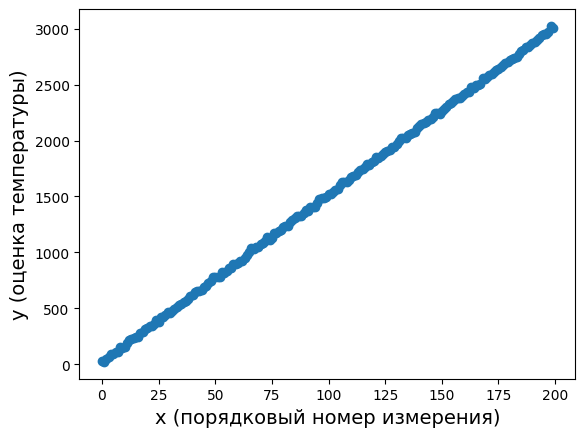

In [ ]:
def datasets_make_regression(coef, data_size, noise_sigma, random_state):
    x = np.arange(0, data_size, 1.)
    mu = 0.0
    random.seed(random_state)
    noise = np.empty((data_size, 1))
    y = np.empty((data_size, 1))

    for i in range(data_size):
        noise[i] = random.gauss(mu, noise_sigma)
        y[i] = coef[0] + coef[1]*x[i] + noise[i]

    return x, y

coef_true = [18.0, 15.0] # весовые коэффициенты
data_size = 200 # размер генерируемого набора данных
noise_sigma = 10 # СКО шума в данных
random_state = 145
x_scale, y_estimate = datasets_make_regression(coef_true, data_size, noise_sigma, random_state)

plt.plot(x_scale, y_estimate, 'o')
plt.xlabel('x (порядковый номер измерения)', fontsize=14)
plt.ylabel('y (оценка температуры)', fontsize=14)

## Первый алгоритм
$\begin{pmatrix}w_{1}^{*}\\ w_{0}^{*}\end{pmatrix}$ = $\begin{pmatrix}\sum_{i=1}^{n}x_{i}^{2}&\sum_{i=1}^{n}x_{i}\\ \sum_{i=1}^{n}x_{i}&n\end{pmatrix}^{-1}$
$\begin{pmatrix}\sum_{i=1}^{n}y_{i}x_{i}\\ \sum_{i=1}^{n}y_{i}\end{pmatrix}$.

In [ ]:
def coefficient_reg_inv(x, y):
    size = len(x)
    # формируем и заполняем матрицу размерностью 2x2
    A = np.empty((2, 2))
    A[[0], [0]] = sum((x[i])**2 for i in range(0,size))
    A[[0], [1]] = sum(x)
    A[[1], [0]] = sum(x)
    A[[1], [1]] = size
    # находим обратную матрицу
    A = np.linalg.inv(A)
    # формируем и заполняем матрицу размерностью 2x1
    C = np.empty((2, 1))
    C[0] = sum((x[i]*y[i]) for i in range(0,size))
    C[1] = sum((y[i]) for i in range(0,size))

    # умножаем матрицу на вектор
    ww = np.dot(A, C)
    return ww[1], ww[0]

In [ ]:
[w0_1, w1_1] = coefficient_reg_inv(x_scale, y_estimate)
print(w0_1, w1_1)

[18.34922034] [15.00940691]


## Второй алгоритм
$\begin{pmatrix}w_{1}^{*}\\ w_{0}^{*}\end{pmatrix}$ =
$\begin{pmatrix}
\frac{n*\sum_{i=1}^{n}y_ix_i -\sum_{i=1}^{n}x_i * \sum_{i=1}^{n}y_i}
{n*\sum_{i=1}^{n}x_i^{2} -(\sum_{i=1}^{n}x_i)^{2}}\\
\frac{-\sum_{i=1}^{n}x_i *\sum_{i=1}^{n}y_ix_i + \sum_{i=1}^{n}x_i^{2}*\sum_{i=1}^{n}x_i}
{n*\sum_{i=1}^{n}x_i^{2} -(\sum_{i=1}^{n}x_i)^{2}}
 \end{pmatrix}$.

In [ ]:
def coefficient_reg_inv_analit(x, y):
    size = len(x)
    # выполним расчет числителя первого элемента вектора
    numerator_w1 = size*sum(x[i]*y[i] for i in range(0,size)) - sum(x)*sum(y)
    # выполним расчет знаменателя (одинаковый для обоих элементов вектора)
    denominator = size*sum((x[i])**2 for i in range(0,size)) - (sum(x))**2
    # выполним расчет числителя второго элемента вектора
    numerator_w0 = -sum(x)*sum(x[i]*y[i] for i in range(0,size)) + sum((x[i])**2 for i in range(0,size))*sum(y)

    # расчет искомых коэффициентов
    w1 = numerator_w1/denominator
    w0 = numerator_w0/denominator
    return w0, w1

In [ ]:
[w0_2, w1_2] = coefficient_reg_inv_analit(x_scale, y_estimate)
print(w0_2, w1_2)

[18.34922034] [15.00940691]


## Третий алгоритм
$\begin{align*}
w_{1}^{*} & = r_{xy}  * \frac{\sigma_y}{\sigma_x}\\
w_{0}^{*} &= \overline{y} - \overline{x}*w_{1}^{*}
\end{align*}$

In [ ]:
def coefficient_reg_stat(x, y):
    size = len(x)
    avg_x = sum(x)/len(x) # оценка МО величины x
    avg_y = sum(y)/len(y) # оценка МО величины y
    # оценка МО величины x*y
    avg_xy = sum(x[i]*y[i] for i in range(0,size))/size
    # оценка СКО величины x
    std_x = (sum((x[i] - avg_x)**2 for i in range(0,size))/size)**0.5
    # оценка СКО величины y
    std_y = (sum((y[i] - avg_y)**2 for i in range(0,size))/size)**0.5
    # оценка коэффициента корреляции величин x и y
    corr_xy = (avg_xy - avg_x*avg_y)/(std_x*std_y)

    # расчет искомых коэффициентов
    w1 = corr_xy*std_y/std_x
    w0 = avg_y - avg_x*w1
    return w0, w1

In [ ]:
[w0_3, w1_3] = coefficient_reg_stat(x_scale, y_estimate)
print(w0_3, w1_3)

[18.34922034] [15.00940691]


## Проверка работы методов при помощи sklearn

In [ ]:
from sklearn.linear_model import LinearRegression
# преобразование размерности массива x_scale для корректной работы model.fit
x_scale = x_scale.reshape((-1,1))
model = LinearRegression()
model.fit(x_scale, y_estimate)
print(model.intercept_, model.coef_)

[18.34922034] [[15.00940691]]


In [ ]:
def predict(w0, w1, x_scale):
    y_pred = [w0 + val*w1 for val in x_scale]
    return y_pred

Text(0, 0.5, 'y (оценка температуры)')

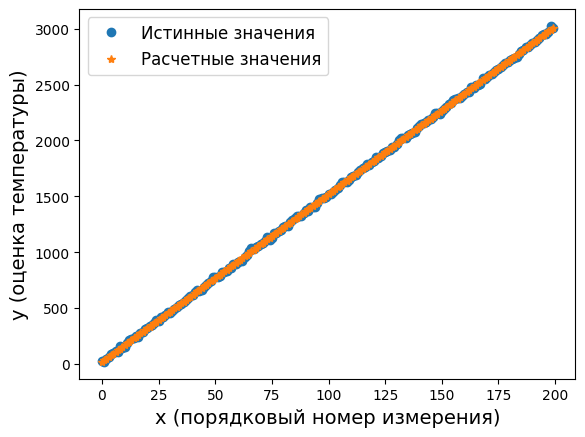

In [ ]:
y_predict = predict(w0_1, w1_1, x_scale)

plt.plot(x_scale, y_estimate, 'o', label = 'Истинные значения')
plt.plot(x_scale, y_predict, '*', label = 'Расчетные значения')
plt.legend(loc = 'best', fontsize=12)
plt.xlabel('x (порядковый номер измерения)', fontsize=14)
plt.ylabel('y (оценка температуры)', fontsize=14)

## Добавление выбросов

Text(0, 0.5, 'y (оценка температуры)')

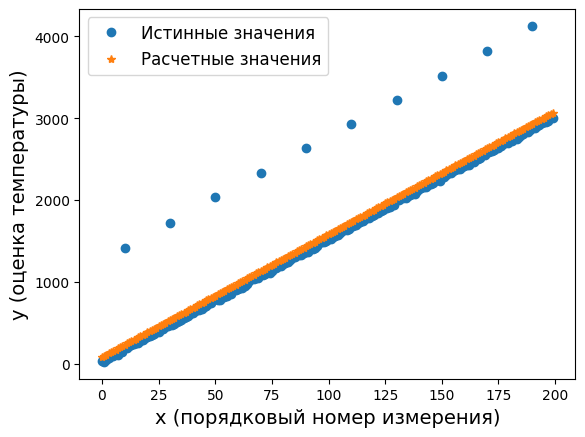

In [ ]:
ni = 10 # количество выбросов
ind_impuls = np.arange(ni, data_size, 20) # индексы выбросов
y_estimate_imp = y_estimate.copy() # выборка с выбросами
for i in range(0, ni):
    y_estimate_imp[ind_impuls[i]] += 1256

[w0_imp, w1_imp] = coefficient_reg_stat(x_scale, y_estimate_imp)
y_pred_imp = predict(w0_imp, w1_imp, x_scale)
plt.plot(x_scale, y_estimate_imp, 'o', label = 'Истинные значения')
plt.plot(x_scale, y_pred_imp, '*', label = 'Расчетные значения')
plt.legend(loc = 'best', fontsize=12)
plt.xlabel('x (порядковый номер измерения)', fontsize=14)
plt.ylabel('y (оценка температуры)', fontsize=14)

## Квадраты ошибок
$\begin{equation}
SE_i = (w_0 + w_1 x_i - y_i)^2, i = \overline{1, n}.
\end{equation}$

Text(0, 0.5, 'Квадрат ошибки')

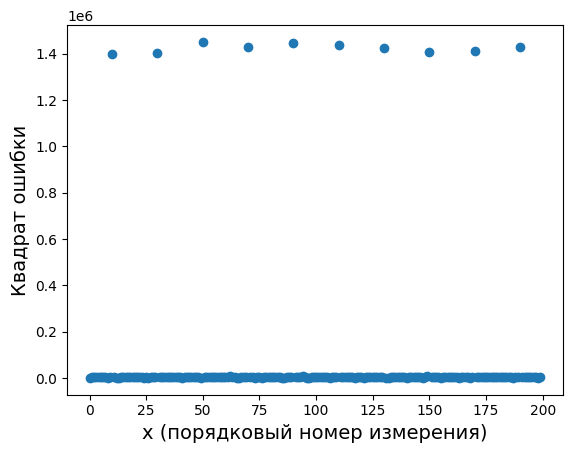

In [ ]:
SqErr = (y_pred_imp - y_estimate_imp)**2

plt.plot(x_scale, SqErr, 'o')
plt.xlabel('x (порядковый номер измерения)', fontsize=14)
plt.ylabel('Квадрат ошибки', fontsize=14)

## Цензорирование данных (отбрасывание значений с высоким значением квардрата ошибки) и оценка параметров w0 и w1 для осташихся значений по третьему алгоритму

In [ ]:
def censor_data(SqErr, nCensor):
    # индексы отсортированного во возрастанию массива с квадратами ошибок
    I = np.argsort(SqErr[:,0])
    ind_imp = I[-nCensor:]
    ind_imp = ind_imp[::-1] # разворот индексов массива
    w0 = np.empty((nCensor, 1))
    w1 = np.empty((nCensor, 1))

    for i in range(0, nCensor):
        # цензурирование данных
        x_scale_cens = np.delete(x_scale, ind_imp[0:i], 0)
        y_estimate_imp_cens = np.delete(y_estimate_imp, ind_imp[0:i], 0)
        # расчёт параметров модельной прямой
        w0[i], w1[i] = coefficient_reg_stat(x_scale_cens, y_estimate_imp_cens)
        y_pred2_cens = predict(w0[i], w1[i], x_scale_cens)
    return w0, w1

## Обработанные значения весов для расчетных значений по сравнению с истинным значением

Text(0, 0.5, 'w1')

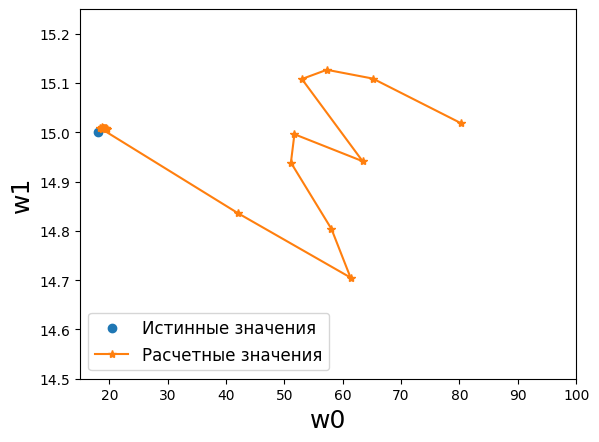

In [ ]:
nCensor = 20 # количество отбрасываемых выбросов
[w0_с, w1_с] = censor_data(SqErr, nCensor)

plt.plot(coef_true[0], coef_true[1], 'o', label = 'Истинные значения')
plt.plot(w0_с, w1_с, '-*', label = 'Расчетные значения')
plt.legend(loc = 'best', fontsize=12)
plt.xlim((15, 100))
plt.ylim((14.5, 15.25))
plt.xlabel('w0', fontsize=18)
plt.ylabel('w1', fontsize=18)

## Результаты 3-го алгоритма с цензурированием

Text(0, 0.5, 'Y (оценка температуры)')

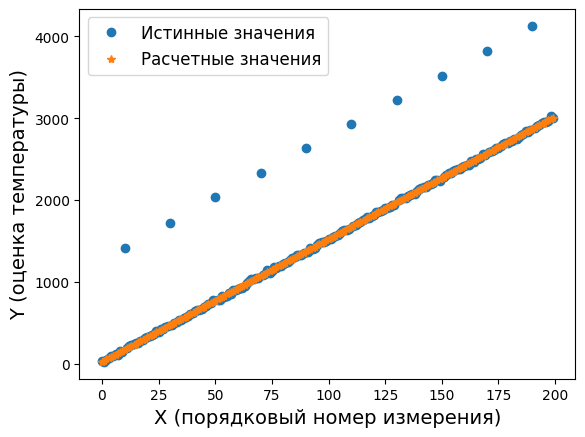

In [ ]:
y_pred_censor = predict(w0_с[nCensor-1], w1_с[nCensor-1], x_scale) # most censored w-pair is taken

plt.plot(x_scale, y_estimate_imp, 'o', label = 'Истинные значения')
plt.plot(x_scale, y_pred_censor, '*', label = 'Расчетные значения')
plt.legend(loc = 'best', fontsize=12)
plt.xlabel('X (порядковый номер измерения)', fontsize=14)
plt.ylabel('Y (оценка температуры)', fontsize=14)

Линейная регрессия позволила получить с высокой точностью закон изменения величины температуры камеры сгорания в зависимости от порядкового номера замера, причем, при использовании цензорирования есть возможность легко избавиться от выбросов и не позволить им испортить получаемые значения.